# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [278]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [279]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

## Análise e visualização de ativos

### Carrega Dados

In [280]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3518, 4)

<Axes: ylabel='Date'>

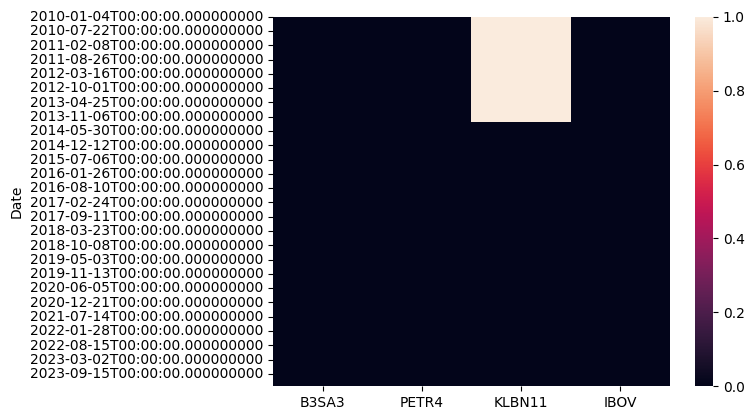

In [281]:
sns.heatmap(acoes_df.isnull())

In [282]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,3.250000,15.470000,11.744000,48321.0
2014-01-24,3.233333,15.100000,11.744000,47787.0
2014-01-27,3.300000,15.110000,11.744000,47701.0
2014-01-28,3.280000,15.050000,12.586000,47841.0
2014-01-29,3.170000,14.800000,12.350000,47557.0
...,...,...,...,...
2024-03-04,12.300000,40.080002,22.510000,128341.0
2024-03-05,12.190000,39.959999,22.299999,128098.0
2024-03-06,12.250000,40.840000,22.150000,128890.0


### Visualização dos dados 

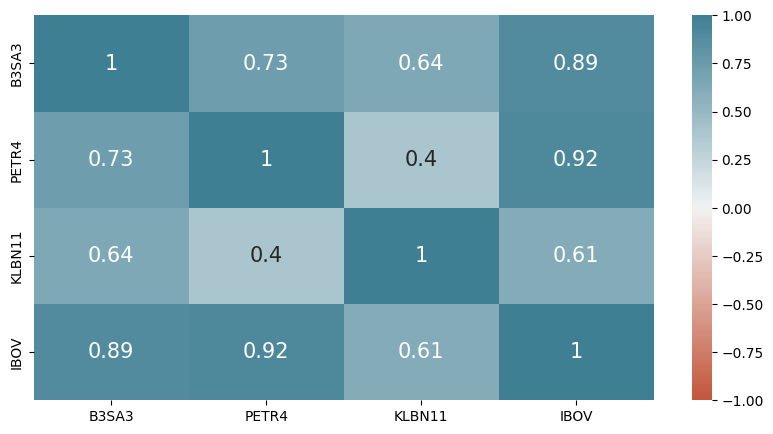

In [283]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [284]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [285]:
acoes_df_normalized

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,1.000000,1.000000,1.000000,1.000000
2014-01-24,0.994872,0.976083,1.000000,0.988949
2014-01-27,1.015385,0.976729,1.000000,0.987169
2014-01-28,1.009231,0.972851,1.071696,0.990066
2014-01-29,0.975385,0.956690,1.051601,0.984189
...,...,...,...,...
2024-03-04,3.784615,2.590821,1.916723,2.656009
2024-03-05,3.750769,2.583064,1.898842,2.650980
2024-03-06,3.769231,2.639948,1.886069,2.667370


In [286]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [287]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [288]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [289]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [290]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"
ticker = "B3SA3"


if ticker!="^BVSP":
    ticker=ticker+".SA"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')

# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()

[*********************100%%**********************]  1 of 1 completed


In [291]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [292]:
# Function to compute Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [293]:
def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)


In [294]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [295]:
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variacao'] = ((df['Close'].shift(-7) - df['Close']) / df['Close'])*100

# Definir a variável alvo com base na variação percentual
df['Subida'] = df['Variacao'].apply(lambda x: 1 if x > 1 else 0)

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df

,Date,Open,High,Low,Close,Adj Close,Volume,EMA9,EMA20,EMA50,...,MACD,Signal,upper_band_bollinger,lower_band_bollinger,Variacao,Subida,weekday,day,month,quarter
0,2015-01-02,3.270000,3.270000,3.150000,3.170000,2.279344,21734100,3.170000,3.170000,3.170000,...,0.000000,0.000000,0.000000,0.000000,-4.521582,0,5,2,1,1
1,2015-01-05,3.143333,3.153333,3.056666,3.083333,2.217026,34790100,3.121852,3.124500,3.125800,...,-0.006914,-0.001383,0.000000,0.000000,0.108100,0,1,5,1,1
2,2015-01-06,3.066666,3.113333,3.033333,3.113333,2.238598,49214700,3.118360,3.120399,3.121477,...,-0.009858,-0.003078,0.000000,0.000000,-1.284795,0,2,6,1,1
3,2015-01-07,3.133333,3.283333,3.126666,3.236666,2.327280,24006600,3.158437,3.153964,3.152025,...,-0.002215,-0.002905,0.000000,0.000000,-2.162717,0,3,7,1,1
4,2015-01-08,3.296666,3.300000,3.190000,3.193333,2.296121,22967700,3.168818,3.163487,3.160960,...,0.000343,-0.002256,0.000000,0.000000,-6.263043,0,4,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,2024-03-04,12.420000,12.440000,12.260000,12.300000,12.300000,32530100,12.590606,12.809560,13.126310,...,-0.260912,-0.250302,13.444275,12.201724,0.000000,0,1,4,3,1
2279,2024-03-05,12.390000,12.410000,12.110000,12.190000,12.190000,41616100,12.510484,12.750554,13.089592,...,-0.278388,-0.255919,13.433454,12.114545,0.000000,0,2,5,3,1
2280,2024-03-06,12.280000,12.360000,12.140000,12.250000,12.250000,64366000,12.458388,12.702882,13.056667,...,-0.284121,-0.261560,13.416493,12.049507,0.000000,0,3,6,3,1
2281,2024-03-07,12.240000,12.400000,12.110000,12.320000,12.320000,43360500,12.430710,12.666417,13.027778,...,-0.279791,-0.265206,13.356955,12.020044,0.000000,0,4,7,3,1


## Tratamento de dados para Predição de ativos

### Pré-processamento dos dados para predição 

In [296]:
ticker

'B3SA3.SA'

In [297]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
acoes_df = acoes_df[['Date', ticker]]
acoes_df.columns = ['ds', 'y']

In [298]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [299]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
#features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200']
#features_indicators=[]
#features_indicators=['EMA9', 'EMA20']

acoes_df = df[['Close']+features_indicators]  
acoes_df_normalized = acoes_df / acoes_df.max().values
acoes_df_normalized.describe()
acoes_df['ds']=df['Date']

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2568\1102800203.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [300]:
#lookback = 23  # number of past days used to predict the future value
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data, features_indicators):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        #X += [data[['Close']+features_indicators].values[win-lookback:win]]
        #X_inputs=comput_features(data['Close'].values[:win],lookback, features_indicators).reshape(1,-1)
        #X +=[X_inputs]
        X +=[np.concatenate([data['Close'].values[win-lookback:win],data[features_indicators].values[win]])]
        y += [data[['Close']].values[win:win+pred_days]]
    X=np.array(X)
    X=np.nan_to_num(np.vstack(X.T).T)
    y=np.vstack(y)
    return X, y

X, y = windowing(df,features_indicators)
date_time=acoes_df['ds'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2260, 32)
y shape (2260, 1)
Last Date 2024-03-08T00:00:00.000000000


In [301]:
features_scaler = MinMaxScaler()
X=features_scaler.fit_transform(X)

scaler = MinMaxScaler()
y=scaler.fit_transform(y)

In [302]:
def comput_features(data_array, lookback, features_indicators):

    df_=pd.DataFrame(data=scaler.inverse_transform(data_array.reshape(-1,1)),columns=['Close'])
    #df_=pd.DataFrame(data=data_array.reshape(-1,1),columns=['Close'])

    df_['upper_band_bollinger'],df_['lower_band_bollinger']=calculate_bollinger_bands(df)
    # Calcula as EMAs de 9 e 20 períodos
    df_['EMA9'] = df_['Close'].ewm(span=9).mean()
    df_['EMA20'] = df_['Close'].ewm(span=20).mean()
    df_['EMA50'] = df_['Close'].ewm(span=50).mean()
    df_['EMA100'] = df_['Close'].ewm(span=100).mean()
    df_['EMA200'] = df_['Close'].ewm(span=200).mean()

    # Calculate RSI (14-period)
    df_['RSI_14'] = calculate_rsi(df, window=14)

    # Calculate MACD (12, 26, 9)
    df_['MACD'], df_['Signal'] = calculate_macd(df_, short_window=12, long_window=26, signal_window=9)

    #return  df_[['Close']+features_indicators].iloc[-lookback:,:].values.reshape(1,-1)
    X_features=features_scaler.transform(np.concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1))
    #X_features=np.concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1)
    return X_features


In [303]:
'''lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        X += [data[win-lookback:win]]
        y += [data[win:win+pred_days]]  
    X=np.vstack(X)
    y=np.array(y)
    return X, y

X, y = windowing(acoes_df_norm['y'].values)
date_time=acoes_df['ds'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y shape",y.shape)
print("Last Date",date_time.values[-1])'''

'lookback = 23  # number of past days used to predict the future value\npred_days = 1  # number of future days to predict\ndef windowing(data):\n    X = []\n    y = []\n    x_time = []\n    for win in np.arange(lookback,len(data),1):\n        X += [data[win-lookback:win]]\n        y += [data[win:win+pred_days]]  \n    X=np.vstack(X)\n    y=np.array(y)\n    return X, y\n\nX, y = windowing(acoes_df_norm[\'y\'].values)\ndate_time=acoes_df[\'ds\'][lookback:]\n#date_time =date_time_old + datetime.timedelta(days=pred_days)\n\nprint("X shape",X.shape)\nprint("y shape",y.shape)\nprint("Last Date",date_time.values[-1])'

In [304]:
# separa os dados em Treino e Teste
def split_data(X,y,date_time,factor=0.70):
    nits=round(len(X)*factor)
    X_train=X[:nits,:]
    nit_test= np.max(X_train.shape) -1
    X_test=X[nit_test:,:]

    y_train=y[:nits]
    y_test =y[nit_test:]
    
    T_train=date_time[:nits]
    T_test =date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [305]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train ,y=np.squeeze(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.squeeze(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)
fig.show()

## Modelos de rede neural

### CNN_LSTM

In [306]:
X.shape

(2260, 32)

In [307]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model_CNN_LSTM=dense_layers(features, n_outputs = pred_days)
model_CNN_LSTM._name=model_name
model_CNN_LSTM.summary()

Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 14, 64)            384       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 7, 64)             0         
 g1D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 7, 64)             0         
                                                                 
 flatten_4 (Flatten)         (None, 448)               0         
                                                                 
 dense_40 (Dense)            (None, 32)                14368     
                                                                 
 activation_8 (Activation)   (None, 32)                0         
                                                          

### MultiLayer Perceptron

In [308]:
model_name= "MLP"
# Camada de entrada
input_data = Input(shape=(X.shape[1],))

dense_output = Dense(64, activation='relu')(input_data)
#dense_output=Dropout(0.2)(dense_output)

dense_output = Dense(128, activation='relu')(dense_output)
dense_output=Dropout(0.2)(dense_output)

#dense_output = Dense(10, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

# Camada de saída
output = Dense(1, activation='linear')(dense_output)


model_MLP = Model(inputs=input_data, outputs=output)
model_MLP._name=model_name
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_42 (Dense)            (None, 64)                2112      
                                                                 
 dense_43 (Dense)            (None, 128)               8320      
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 1)                 129       
                                                                 
Total params: 10561 (41.25 KB)
Trainable params: 10561 (41.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Long Short-Term Memory (LSTM) 

In [309]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, activation='relu', return_sequences=False)(input_data)
Dropout_output = Dropout(0.2)(lstm_output)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Long Short-Term Memory (GRU) 

In [310]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64, activation='relu')(input_data)
Dropout_output = Dropout(0.2)(GRU_output)
output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 gru_4 (GRU)                 (None, 64)                12864     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM with Attention layer

In [311]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [312]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

x = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_data)
x = Dropout(0.2)(x)
x = Attention(64)(x)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 lstm_9 (LSTM)               (None, 32, 64)            16896     
                                                                 
 dropout_24 (Dropout)        (None, 32, 64)            0         
                                                                 
 attention_4 (Attention)     (None, 64)                4225      
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21186 (82.76 KB)
Trainable params: 21186 (82.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Hiperparâmetros para de treinamento

**Metrics and Loss Functions**  

In [313]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [314]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    return optimizer1
    #optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.05)

**Train options callbacks**  

In [315]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

Training model : models/model_MLP_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP


Epoch 1/200
37/42 [=========================>....] - ETA: 0s - loss: 1.7947 - NRMSE: 0.5754
Epoch 1: val_loss improved from inf to 0.02662, saving model to models\model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 3s 47ms/step - loss: 1.5829 - NRMSE: 0.6112 - val_loss: 0.0266 - val_NRMSE: 0.8490 - lr: 0.0500
Epoch 2/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0108 - NRMSE: 0.8985
Epoch 2: val_loss improved from 0.02662 to 0.00206, saving model to models\model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 1s 30ms/step - loss: 0.0109 - NRMSE: 0.8981 - val_loss: 0.0021 - val_NRMSE: 0.9587 - lr: 0.0500
Epoch 3/200
36/42 [========================>.....] - ETA: 0s - loss: 0.0094 - NRMSE: 0.9053
Epoch 3: val_loss improved from 0.00206 to 0.00186, saving model to models\model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 1s 31ms/step - loss: 0.0093 - NRMSE: 0.9062 - val_loss: 0.0019 - val_NRMSE: 0.9574 - lr: 0.0500
Epoch 4/200
36/42 [========================>.....] - ETA: 0s - loss: 0.0084 - NRMSE: 0.9105
Epoch 4: val_loss did not improve from 0.00186
42/42 [==============================] - 0s 6ms/step - loss: 0.0082 - NRMSE: 0.9115 - val_loss: 0.0027 - val_NRMSE: 0.9484 - lr: 0.0500
Epoch 5/200
38/42 [==========================>...] - ETA: 0s - loss: 0.0075 - NRMSE: 0.9158
Epoch 5: val_loss improved from 0.00186 to 0.00120, saving model to models\model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 2s 44ms/step - loss: 0.0073 - NRMSE: 0.9171 - val_loss: 0.0012 - val_NRMSE: 0.9685 - lr: 0.0500
Epoch 6/200
29/42 [===================>..........] - ETA: 0s - loss: 0.0065 - NRMSE: 0.9210
Epoch 6: val_loss improved from 0.00120 to 0.00119, saving model to models\model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 2s 45ms/step - loss: 0.0061 - NRMSE: 0.9235 - val_loss: 0.0012 - val_NRMSE: 0.9655 - lr: 0.0500
Epoch 7/200
27/42 [==================>...........] - ETA: 0s - loss: 0.0045 - NRMSE: 0.9344
Epoch 7: val_loss did not improve from 0.00119
42/42 [==============================] - 0s 7ms/step - loss: 0.0049 - NRMSE: 0.9319 - val_loss: 0.0014 - val_NRMSE: 0.9619 - lr: 0.0500
Epoch 8/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0047 - NRMSE: 0.9336
Epoch 8: val_loss did not improve from 0.00119
42/42 [==============================] - 0s 7ms/step - loss: 0.0046 - NRMSE: 0.9341 - val_loss: 0.0031 - val_NRMSE: 0.9443 - lr: 0.0500
Epoch 9/200
34/42 [=======================>......] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9432
Epoch 9: val_loss improved from 0.00119 to 0.00068, saving model to models\model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 2s 46ms/step - loss: 0.0035 - NRMSE: 0.9433 - val_loss: 6.7934e-04 - val_NRMSE: 0.9738 - lr: 0.0500
Epoch 10/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9433
Epoch 10: val_loss did not improve from 0.00068
42/42 [==============================] - 0s 6ms/step - loss: 0.0033 - NRMSE: 0.9435 - val_loss: 0.0069 - val_NRMSE: 0.9231 - lr: 0.0500
Epoch 11/200
41/42 [============================>.] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9462
Epoch 11: val_loss improved from 0.00068 to 0.00065, saving model to models\model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 3s 77ms/step - loss: 0.0031 - NRMSE: 0.9463 - val_loss: 6.5136e-04 - val_NRMSE: 0.9746 - lr: 0.0500
Epoch 12/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0028 - NRMSE: 0.9491
Epoch 12: val_loss did not improve from 0.00065
42/42 [==============================] - 0s 6ms/step - loss: 0.0027 - NRMSE: 0.9495 - val_loss: 0.0013 - val_NRMSE: 0.9670 - lr: 0.0500
Epoch 13/200
29/42 [===================>..........] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9443
Epoch 13: val_loss did not improve from 0.00065
42/42 [==============================] - 0s 6ms/step - loss: 0.0032 - NRMSE: 0.9452 - val_loss: 0.0024 - val_NRMSE: 0.9507 - lr: 0.0500
Epoch 14/200
35/42 [========================>.....] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9502
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 14: val_loss did not improve from 0.00065
42/42 [==============================] - 0s 6ms/step - loss: 0.0029 - NRMSE: 0.9479 - v

INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 2s 39ms/step - loss: 0.0030 - NRMSE: 0.9471 - val_loss: 5.5946e-04 - val_NRMSE: 0.9766 - lr: 0.0100
Epoch 16/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0026 - NRMSE: 0.9513
Epoch 16: val_loss did not improve from 0.00056
42/42 [==============================] - 0s 6ms/step - loss: 0.0025 - NRMSE: 0.9519 - val_loss: 5.7984e-04 - val_NRMSE: 0.9754 - lr: 0.0100
Epoch 17/200
42/42 [==============================] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9533
Epoch 17: val_loss did not improve from 0.00056
42/42 [==============================] - 0s 5ms/step - loss: 0.0023 - NRMSE: 0.9533 - val_loss: 9.3484e-04 - val_NRMSE: 0.9718 - lr: 0.0100
Epoch 18/200
41/42 [============================>.] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9557
Epoch 18: val_loss did not improve from 0.00056
42/42 [==============================] - 0s 5ms/step - loss: 0.0021 - NRMSE: 0.9554 - val_loss: 6.3338e-04 - val_NRMSE: 0.9743 - lr: 0.0100
Epoch 19/200
38/

INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 1s 33ms/step - loss: 0.0026 - NRMSE: 0.9501 - val_loss: 5.3943e-04 - val_NRMSE: 0.9765 - lr: 0.0020
Epoch 24/200
33/42 [======================>.......] - ETA: 0s - loss: 0.0028 - NRMSE: 0.9488
Epoch 24: val_loss improved from 0.00054 to 0.00053, saving model to models\model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 1s 33ms/step - loss: 0.0027 - NRMSE: 0.9495 - val_loss: 5.3294e-04 - val_NRMSE: 0.9767 - lr: 0.0020
Epoch 25/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9521
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 25: val_loss did not improve from 0.00053
42/42 [==============================] - 0s 6ms/step - loss: 0.0025 - NRMSE: 0.9519 - val_loss: 8.6179e-04 - val_NRMSE: 0.9728 - lr: 0.0020
Epoch 26/200
36/42 [========================>.....] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9555
Epoch 26: val_loss did not improve from 0.00053
42/42 [==============================] - 0s 5ms/step - loss: 0.0021 - NRMSE: 0.9555 - val_loss: 7.3524e-04 - val_NRMSE: 0.9745 - lr: 4.0000e-04
Epoch 27/200
38/42 [==========================>...] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9523
Epoch 27: val_loss did not improve from 0.00053
42/42 [==============================] - 0s 6ms/step - loss: 0.0024 - NRMS

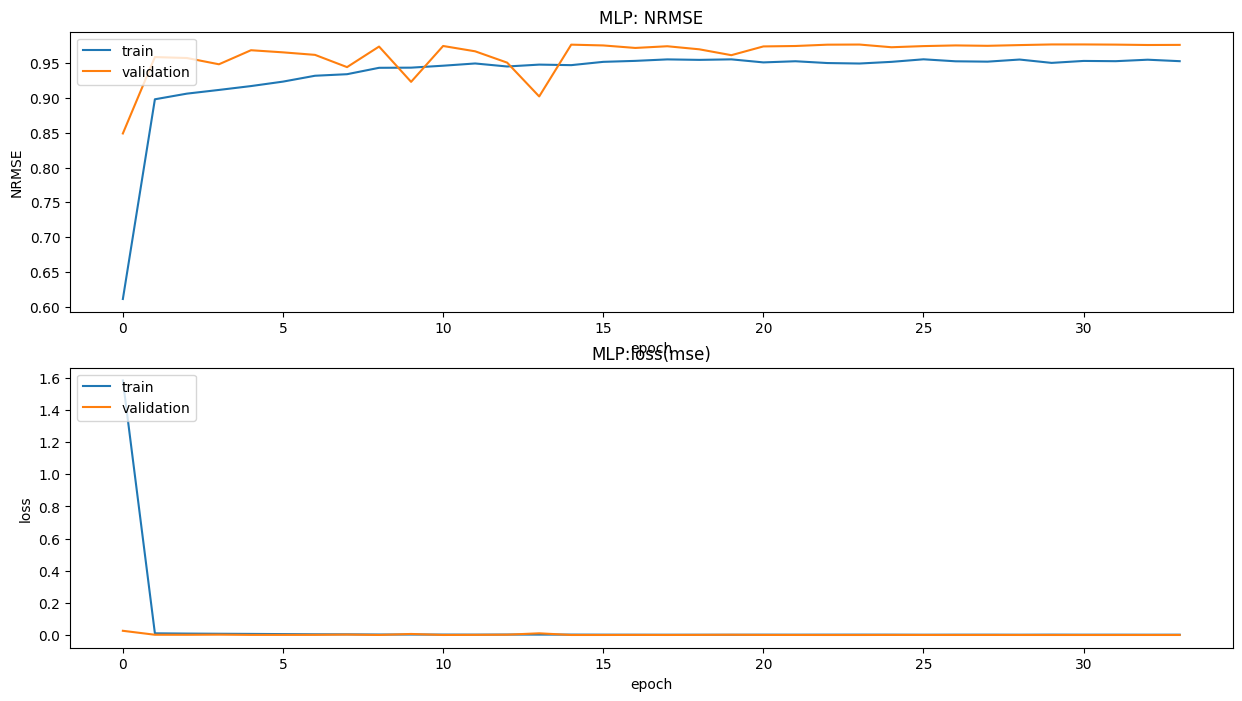

Training model : models/model_GRU_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0876 - NRMSE: 0.7895
Epoch 1: val_loss improved from inf to 0.00373, saving model to models\model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 6s 103ms/step - loss: 0.0839 - NRMSE: 0.7948 - val_loss: 0.0037 - val_NRMSE: 0.9485 - lr: 0.0500
Epoch 2/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0074 - NRMSE: 0.9166
Epoch 2: val_loss did not improve from 0.00373
42/42 [==============================] - 1s 21ms/step - loss: 0.0074 - NRMSE: 0.9165 - val_loss: 0.0073 - val_NRMSE: 0.9198 - lr: 0.0500
Epoch 3/200
42/42 [==============================] - ETA: 0s - loss: 0.0064 - NRMSE: 0.9220
Epoch 3: val_loss did not improve from 0.00373
42/42 [==============================] - 1s 21ms/step - loss: 0.0064 - NRMSE: 0.9220 - val_loss: 0.0042 - val_NRMSE: 0.9428 - lr: 0.0500
Epoch 4/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0067 - NRMSE: 0.9210
Epoch 4: val_loss did not improve from 0.00373
42/42 [==============================] - 1s 21ms/step - loss: 0.0068 - NRMSE: 0.9201 - val_loss: 0.0072 - val_NRMSE: 0.9348 - lr: 0.0500
Epoch 5/200
41/42 [===============

INFO:tensorflow:Assets written to: models\model_GRU_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 3s 85ms/step - loss: 0.0056 - NRMSE: 0.9268 - val_loss: 0.0021 - val_NRMSE: 0.9591 - lr: 0.0500
Epoch 7/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0056 - NRMSE: 0.9276
Epoch 7: val_loss did not improve from 0.00215
42/42 [==============================] - 1s 21ms/step - loss: 0.0056 - NRMSE: 0.9279 - val_loss: 0.0051 - val_NRMSE: 0.9445 - lr: 0.0500
Epoch 8/200
42/42 [==============================] - ETA: 0s - loss: 0.0054 - NRMSE: 0.9293
Epoch 8: val_loss did not improve from 0.00215
42/42 [==============================] - 1s 24ms/step - loss: 0.0054 - NRMSE: 0.9293 - val_loss: 0.0139 - val_NRMSE: 0.9144 - lr: 0.0500
Epoch 9/200
41/42 [============================>.] - ETA: 0s - loss: 0.0050 - NRMSE: 0.9309
Epoch 9: val_loss did not improve from 0.00215
42/42 [==============================] - 1s 22ms/step - loss: 0.0051 - NRMSE: 0.9299 - val_loss: 0.0102 - val_NRMSE: 0.9239 - lr: 0.0500
Epoch 10/200
42/42 [===============

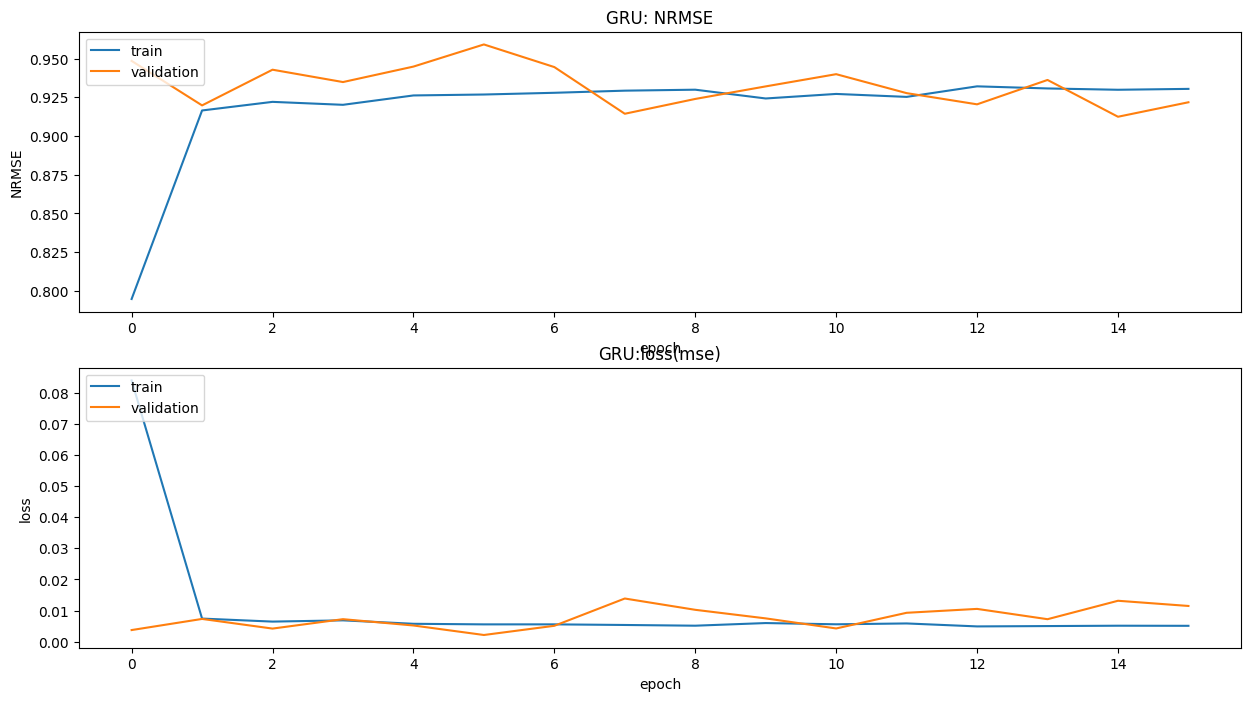

Training model : models/model_CNN_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM
Epoch 1/200
28/42 [===================>..........] - ETA: 0s - loss: 5.5236 - NRMSE: 0.3428  
Epoch 1: val_loss improved from inf to 0.00385, saving model to models\model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 4s 59ms/step - loss: 3.6840 - NRMSE: 0.5397 - val_loss: 0.0038 - val_NRMSE: 0.9445 - lr: 0.0500
Epoch 2/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9419
Epoch 2: val_loss did not improve from 0.00385
42/42 [==============================] - 0s 7ms/step - loss: 0.0035 - NRMSE: 0.9421 - val_loss: 0.0058 - val_NRMSE: 0.9310 - lr: 0.0500
Epoch 3/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9447
Epoch 3: val_loss improved from 0.00385 to 0.00211, saving model to models\model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 2s 56ms/step - loss: 0.0031 - NRMSE: 0.9454 - val_loss: 0.0021 - val_NRMSE: 0.9576 - lr: 0.0500
Epoch 4/200
41/42 [============================>.] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9541
Epoch 4: val_loss did not improve from 0.00211
42/42 [==============================] - 0s 7ms/step - loss: 0.0022 - NRMSE: 0.9540 - val_loss: 0.0050 - val_NRMSE: 0.9331 - lr: 0.0500
Epoch 5/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9585
Epoch 5: val_loss did not improve from 0.00211
42/42 [==============================] - 0s 7ms/step - loss: 0.0019 - NRMSE: 0.9581 - val_loss: 0.0028 - val_NRMSE: 0.9528 - lr: 0.0500
Epoch 6/200
38/42 [==========================>...] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9629
Epoch 6: val_loss improved from 0.00211 to 0.00044, saving model to models\model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 2s 47ms/step - loss: 0.0014 - NRMSE: 0.9635 - val_loss: 4.3865e-04 - val_NRMSE: 0.9790 - lr: 0.0500
Epoch 7/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9635  
Epoch 7: val_loss did not improve from 0.00044
42/42 [==============================] - 0s 7ms/step - loss: 0.0014 - NRMSE: 0.9636 - val_loss: 9.3885e-04 - val_NRMSE: 0.9696 - lr: 0.0500
Epoch 8/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9664  
Epoch 8: val_loss did not improve from 0.00044
42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - NRMSE: 0.9666 - val_loss: 0.0017 - val_NRMSE: 0.9643 - lr: 0.0500
Epoch 9/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9678
Epoch 9: val_loss did not improve from 0.00044
42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - NRMSE: 0.9678 - val_loss: 7.8331e-04 - val_NRMSE: 0.9718 - lr: 0.0500
Epoch 10/200
32/42 [==

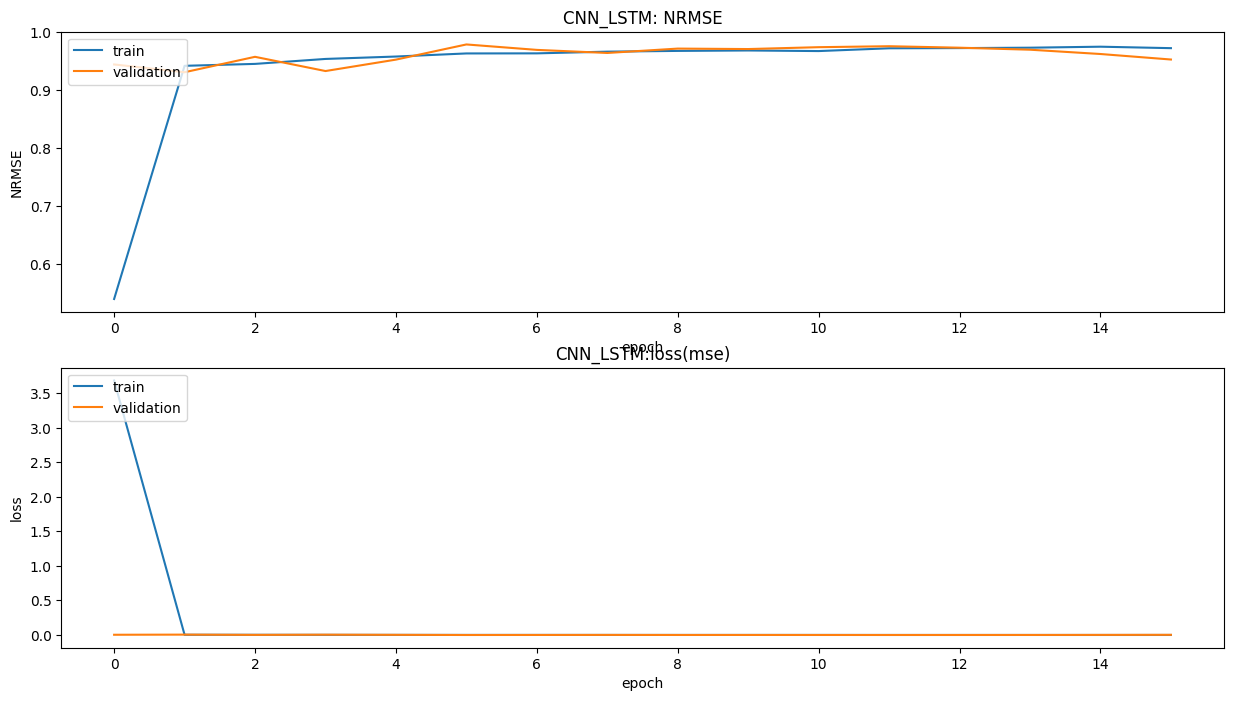

Training model : models/model_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200
41/42 [============================>.] - ETA: 0s - loss: 39360208896.0000 - NRMSE: -30994.9570
Epoch 1: val_loss improved from inf to 0.48767, saving model to models\model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 6s 101ms/step - loss: 38423060480.0000 - NRMSE: -30256.9668 - val_loss: 0.4877 - val_NRMSE: 0.3238 - lr: 0.0500
Epoch 2/200
40/42 [===========================>..] - ETA: 0s - loss: 0.2880 - NRMSE: 0.4677
Epoch 2: val_loss did not improve from 0.48767
42/42 [==============================] - 1s 22ms/step - loss: 0.2835 - NRMSE: 0.4721 - val_loss: 0.7107 - val_NRMSE: 0.1810 - lr: 0.0500
Epoch 3/200
39/42 [==========================>...] - ETA: 0s - loss: 0.1622 - NRMSE: 0.6005
Epoch 3: val_loss improved from 0.48767 to 0.37232, saving model to models\model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 3s 82ms/step - loss: 0.1608 - NRMSE: 0.6022 - val_loss: 0.3723 - val_NRMSE: 0.4266 - lr: 0.0500
Epoch 4/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0874 - NRMSE: 0.7071
Epoch 4: val_loss improved from 0.37232 to 0.17258, saving model to models\model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 6s 144ms/step - loss: 0.0858 - NRMSE: 0.7101 - val_loss: 0.1726 - val_NRMSE: 0.6199 - lr: 0.0500
Epoch 5/200
41/42 [============================>.] - ETA: 0s - loss: 0.0686 - NRMSE: 0.7418
Epoch 5: val_loss improved from 0.17258 to 0.05570, saving model to models\model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 7s 168ms/step - loss: 0.0680 - NRMSE: 0.7430 - val_loss: 0.0557 - val_NRMSE: 0.7837 - lr: 0.0500
Epoch 6/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0606 - NRMSE: 0.7567
Epoch 6: val_loss did not improve from 0.05570
42/42 [==============================] - 1s 29ms/step - loss: 0.0603 - NRMSE: 0.7573 - val_loss: 0.1230 - val_NRMSE: 0.6718 - lr: 0.0500
Epoch 7/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0571 - NRMSE: 0.7643
Epoch 7: val_loss improved from 0.05570 to 0.03404, saving model to models\model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_B3SA3_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_B3SA3_lookback_23\assets


42/42 [==============================] - 5s 132ms/step - loss: 0.0571 - NRMSE: 0.7642 - val_loss: 0.0340 - val_NRMSE: 0.8173 - lr: 0.0500
Epoch 8/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0560 - NRMSE: 0.7662
Epoch 8: val_loss improved from 0.03404 to 0.02758, saving model to models\model_LSTM_stock_B3SA3_lookback_23


In [316]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[NRMSE])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['NRMSE']) 
    history_metric_val=np.array(history.history['val_NRMSE'])  

    plt.figure(1,figsize=(15,8))  
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history_metric[history_metric>0]) 
    plt.plot(history_metric_val[history_metric_val>0])  
    plt.title(f'{model._name}: NRMSE')  
    plt.ylabel('NRMSE')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left') 
    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])   
    plt.title(f'{model._name}:loss(mse)')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validação

In [ ]:
# carrega os modelos terinados
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [ ]:
checkpoint_filepath

'models/model_LSTM_AT_stock_B3SA3_lookback_23'

In [ ]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x248cbce3850>,
 'GRU': <keras.src.engine.functional.Functional at 0x248cc3e8610>,
 'CNN_LSTM': <keras.src.engine.sequential.Sequential at 0x248cd0f0190>,
 'LSTM': <keras.src.engine.functional.Functional at 0x248997bf280>,
 'LSTM_AT': <keras.src.engine.functional.Functional at 0x248cb62ed40>}

In [ ]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(acoes_df,features_indicators)

X_real=features_scaler.transform(X_real)
#y_real=scaler.transform(y_real)
#X_real=features_scaler(X_real)

X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_pred=scaler.inverse_transform(trained_best_models[model_name].predict(X_test))
    r2_score= R2(y_test_real, y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

11/11 [==============================] - 0s 2ms/step
MLP NN R2: 0.8315848142500524
11/11 [==============================] - 0s 14ms/step
GRU NN R2: 0.7199087442925988
11/11 [==============================] - 0s 3ms/step
CNN_LSTM NN R2: 0.8187908243802156
11/11 [==============================] - 0s 11ms/step
LSTM NN R2: -5.3789989736127035
11/11 [==============================] - 0s 11ms/step
LSTM_AT NN R2: -0.31673688506464726


In [ ]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [ ]:
trained_best_models.keys()

dict_keys(['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT'])

In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Geração de valores para predições futuras

In [ ]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-03-06
Estamos Fornecendo dados até o dia : 2024-03-05
O modelo fará previsões até o dia:  2024-03-12


In [ ]:
X_test[:-dias_antes,:]

array([[0.5468082 , 0.53037825, 0.53653947, ..., 0.63521289, 0.60849978,
        0.55340233],
       [0.53037825, 0.53653947, 0.53397233, ..., 0.61882052, 0.60656152,
        0.56127699],
       [0.53653947, 0.53397233, 0.50727369, ..., 0.58605888, 0.6041548 ,
        0.56651509],
       ...,
       [0.52524393, 0.52473049, 0.51394835, ..., 0.43421563, 0.51036738,
        0.54212797],
       [0.52473049, 0.51394835, 0.51856927, ..., 0.42897411, 0.50877878,
        0.53823611],
       [0.51394835, 0.51856927, 0.52883796, ..., 0.42282668, 0.50823382,
        0.53320632]])

In [ ]:
new_predictions=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=-1
    n_steps=2

    if dias_antes == 0:
        NN_predictions=y_test.copy()

        X_inputs=comput_features(y_test,lookback, features_indicators).reshape(1,-1)
        #X_inputs=X_test.copy()
        
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[:-dias_antes].copy()
    
        X_inputs=comput_features(y_test[:-dias_antes,:],lookback, features_indicators).reshape(1,-1)

        #X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    for k in range(n_steps):
        
        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))

        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,comput_features(NN_predictions,lookback, features_indicators).reshape(1,-1),axis=0)
        #X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
        
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]
new_predictions=np.hstack(new_predictions)

1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 283ms/step


In [ ]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
    model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
    model_arima_fit = model_arima.fit()

    arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
    arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
    arima_predictions.shape

Using ARIMA model


In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [ ]:
# modelos treinados 
[model.name for model in list_of_models]

['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT']

In [ ]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.02 else 0)
pred_data_df.tail(10)

,Data,pred,Variacao,Subida
331,2024-02-23,12.450000,-1.606424,0
332,2024-02-26,12.480000,0.240382,1
333,2024-02-27,12.750000,2.117651,1
334,2024-02-28,12.580000,-1.351352,0
335,2024-02-29,12.830000,1.948558,1
336,2024-03-01,12.420000,-3.301126,0
337,2024-03-04,12.300000,-0.975609,0
338,2024-03-05,12.190000,-0.902384,0
339,2024-03-06,12.250000,0.489799,1
340,2024-03-07,12.046184,-1.691956,0


In [ ]:
pred_data_df[pred_data_df['Data']==df['Date'].iloc[-1]]

,Data,pred,Variacao,Subida
339,2024-03-06,12.25,0.489799,1


In [ ]:
result=pred_data_df.iloc[-1:,:]
result

,Data,pred,Variacao,Subida
340,2024-03-07,12.046184,-1.691956,0


In [ ]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )

A previsão para o dia 2024-03-07 é de Descida, de -1.69% o valor predito é de: 12.05


In [ ]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')
model=list_of_models[model_idx]
X_features=comput_features(y_test, lookback, features_indicators).reshape(1,-1)
scaler.inverse_transform(model.predict(X_features))

1/1 [==============================] - 0s 37ms/step


array([[12.046184]], dtype=float32)